# Dataset 1: Airlines Dataset

### Tasks
- 1) Provide an overview of the dataset size, features, and distribution of feature values.
- 2) Describe the average delays per airport/airline.
- 3) Identify and report the most prominent rules of association between delays and point of origin AND/OR point of arrival.
- 4) Try to predict the delay given all other features and report the appropriate performance on cross-validation.
- 5) Identify patterns/rules regarding delays and try to explain when delays should be expected, based on these patterns.

## All the imports 

In [1]:
from scipy.io.arff import loadarff

import pandas as pd
pd.set_option("display.precision", 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import numpy as np

from matplotlib import pyplot as plt
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns


from mlxtend.frequent_patterns import association_rules


# importing Various regression algorithms 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Lasso,LinearRegression,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from xgboost import XGBRegressor



from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori


# with this import we "ignore" the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the file 

In [2]:
raw_data = loadarff('Airlines.arff') 

# the file has been transformed as the attribute 'UniqueCarrier' had a value in '' 
# and it wasnt possible to load the file.
# The transformation that took place is: PA_1 instead of 'PA (1)'

data = pd.DataFrame(raw_data[0])

data

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay
0,5.000,600.000,b'UA',b'899.0',b'ORD',b'IAD',-3.000
1,5.000,615.000,b'DL',b'357.0',b'IAD',b'ATL',5.000
2,5.000,615.000,b'UA',b'341.0',b'IAD',b'DEN',8.000
3,5.000,625.000,b'CO',b'581.0',b'IAD',b'DEN',44.000
4,5.000,630.000,b'UA',b'902.0',b'CLE',b'IAD',-10.000
...,...,...,...,...,...,...,...
100156,6.000,2140.000,b'UA',b'30.0',b'LAX',b'IAD',-19.000
100157,6.000,2140.000,b'CO',b'896.0',b'LAX',b'IAD',-23.000
100158,6.000,2150.000,b'UA',b'1094.0',b'IAD',b'BDL',-14.000
100159,6.000,2155.000,b'US',b'394.0',b'PIT',b'IAD',9.000


In [3]:
#data manipulation 

data = data.astype({"DayofWeek": int, "CRSDepTime": int, "ArrDelay": int})
data['UniqueCarrier']=data['UniqueCarrier'].str.decode("utf-8")
data['FlightNum']=data['FlightNum'].str.decode("utf-8")
data['Origin']=data['Origin'].str.decode("utf-8")
data['Dest']=data['Dest'].str.decode("utf-8")

data

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay
0,5,600,UA,899.0,ORD,IAD,-3
1,5,615,DL,357.0,IAD,ATL,5
2,5,615,UA,341.0,IAD,DEN,8
3,5,625,CO,581.0,IAD,DEN,44
4,5,630,UA,902.0,CLE,IAD,-10
...,...,...,...,...,...,...,...
100156,6,2140,UA,30.0,LAX,IAD,-19
100157,6,2140,CO,896.0,LAX,IAD,-23
100158,6,2150,UA,1094.0,IAD,BDL,-14
100159,6,2155,US,394.0,PIT,IAD,9


# Task1: An overview of the dataset (size, features, distribution of feature values)

In [4]:
#dimension of the dataset

a = len(data)
b = len(data.columns)

print(f"The dataset has {a} instances and {b} Features.")

The dataset has 100161 instances and 7 Features.


In [5]:
#search for missing values

colnames=data.columns
df=pd.DataFrame(columns=["Column","NumOfMissingVal","UniqueVal", "Type"])
for cn in colnames:
    df=df.append({"Column" : cn,
                "NumOfMissingVal": sum(pd.isna(data[cn])),
                "UniqueVal":len(data[cn].unique()),
                "Type" : data[cn].dtypes},
               ignore_index=True)

df

,Column,NumOfMissingVal,UniqueVal,Type
0,DayofWeek,0,7,int32
1,CRSDepTime,0,424,int32
2,UniqueCarrier,0,9,object
3,FlightNum,0,624,object
4,Origin,0,58,object
5,Dest,0,59,object
6,ArrDelay,0,350,int32


In [6]:
# for the numerical attributes we can their Descriptive statistics

data.describe() 

,DayofWeek,CRSDepTime,ArrDelay
count,100161.000,100161.000,100161.000
mean,3.953,1357.918,4.638
std,1.985,460.023,23.398
min,1.000,5.000,-72.000
25%,2.000,925.000,-7.000
50%,4.000,1335.000,0.000
75%,6.000,1735.000,9.000
max,7.000,2359.000,667.000


In [7]:
# unique values of each attribute

colnames=data.columns
for cn in colnames:
    print(cn,"\n" , data[cn].unique(),"\n")

DayofWeek 
 [5 6 7 1 2 3 4] 

CRSDepTime 
 [ 600  615  625  630  635  636  645  647  650  655  700  705  707  710
  720  725  735  755  800  805  810  812  814  815  820  823  825  830
  835  845  850  858  900  902  905  906  908  910  912  915  920  929
  930  940  948 1000 1001 1002 1004 1010 1015 1020 1022 1025 1030 1046
 1050 1120 1129 1130 1140 1159 1200 1202 1204 1205 1206 1210 1215 1218
 1220 1225 1230 1235 1240 1245 1250 1255 1311 1320 1325 1330 1340 1341
 1350 1355 1356 1358 1400 1402 1406 1410 1415 1436 1450 1454 1455 1500
 1510 1515 1520 1522 1524 1525 1527 1528 1530 1532 1534 1535 1537 1538
 1551 1554 1557 1600 1610 1612 1615 1624 1625 1637 1647 1650 1655 1700
 1710 1713 1715 1721 1725 1730 1732 1734 1735 1736 1738 1740 1745 1746
 1750 1754 1755 1800 1805 1815 1825 1830 1835 1840 1851 1859 1905 1915
 1928 1930 1932 1934 1940 1942 1945 1950 1953 1955 1959 2000 2002 2005
 2010 2014 2015 2020 2025 2028 2030 2032 2040 2045 2052 2053 2100 2110
 2130 2135 2137 2140 2200 2205  73

## Overview:
- There are no missing values in the dataset
***
- There are 100.161 non null nalues
***
- Dataset consists of 7 Attributes ( DayofWeek , CRSDepTime, UniqueCarrier, FlightNum, Origin, Dest, ArrDelay)
 - DayofWeek is a numerical attribute with 7 unique values
 - CRSDepTime is the departure time (424 unique values)
 - UniqueCarrier consists of the 9 unique airlines 
 - FlightNum is the number of flight (624 unique values)
 - Origin is the origin airports (58 unique values)
 - Dest is the destination airports (59 unique values)
 - ArrDelay is the delay (350 unique values)
 
***
- 4 out of 7 Attributes are categorical and the rest numerical

<AxesSubplot: xlabel='DayofWeek', ylabel='ArrDelay'>

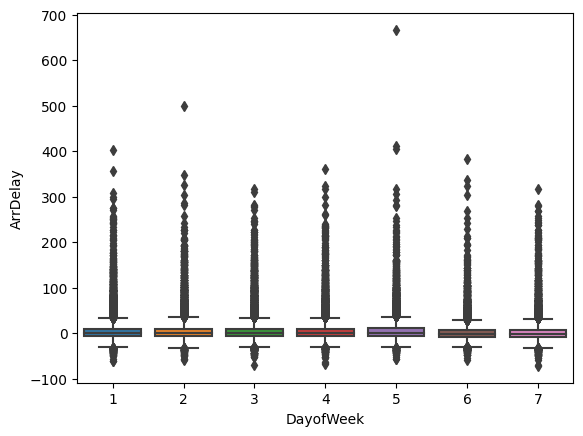

In [8]:
# Create a box plot of the distribution of arrival delay by day of the week

sns.boxplot(x='DayofWeek', y='ArrDelay', data=data)

In [9]:
# we can see that the delays > 350 are just 8 rows.
# From the above graph, it looks like outliers so we took the decision to delete these 5 rows from our dataset

data[data['ArrDelay']> 350]

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay
3088,1,1755,CO,480.0,PBI,IAD,356
12045,5,650,CO,160.0,BOS,IAD,667
12396,6,1220,UA,1043.0,ROC,IAD,384
18013,5,905,CO,151.0,IAD,PBI,405
18053,5,1205,CO,200.0,PBI,IAD,412
19642,4,1235,CO,182.0,MCO,IAD,361
38838,1,1850,UA,916.0,IAD,LGA,402
69965,2,1450,UA,1259.0,MHT,IAD,500


In [10]:
# Now, our dataset consists of 100.153 rows
data = data[data['ArrDelay'] <= 350]
data

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay
0,5,600,UA,899.0,ORD,IAD,-3
1,5,615,DL,357.0,IAD,ATL,5
2,5,615,UA,341.0,IAD,DEN,8
3,5,625,CO,581.0,IAD,DEN,44
4,5,630,UA,902.0,CLE,IAD,-10
...,...,...,...,...,...,...,...
100156,6,2140,UA,30.0,LAX,IAD,-19
100157,6,2140,CO,896.0,LAX,IAD,-23
100158,6,2150,UA,1094.0,IAD,BDL,-14
100159,6,2155,US,394.0,PIT,IAD,9


<AxesSubplot: xlabel='CRSDepTime', ylabel='ArrDelay'>

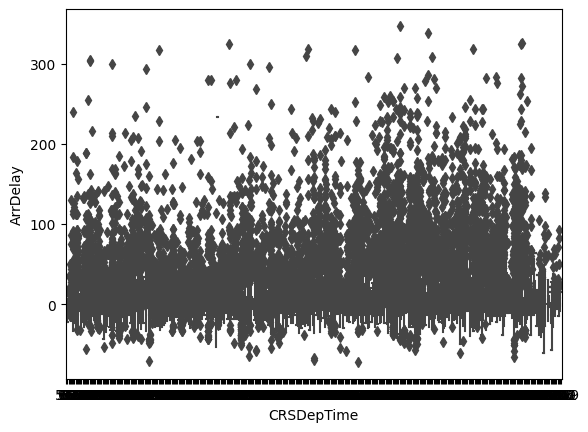

In [11]:
sns.boxplot(x='CRSDepTime', y='ArrDelay', data=data)

<AxesSubplot: xlabel='DayofWeek', ylabel='ArrDelay'>

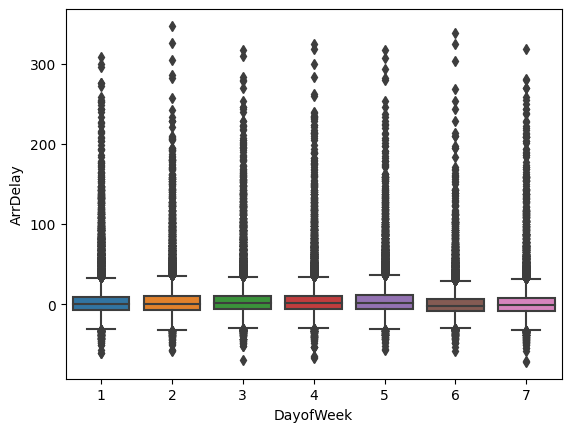

In [12]:
sns.boxplot(x='DayofWeek', y='ArrDelay', data=data)

<AxesSubplot: xlabel='DayofWeek'>

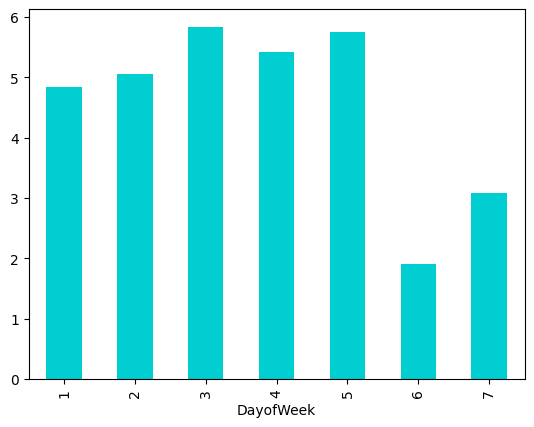

In [13]:
# group the data by day of the week and then plot the average delay for each day.
# As we can see, during the 3rd & 5th day, there are the most delays while on the 6th & 7th day the delays are much less 

data.groupby('DayofWeek')['ArrDelay'].mean().plot(kind='bar', color='darkturquoise')

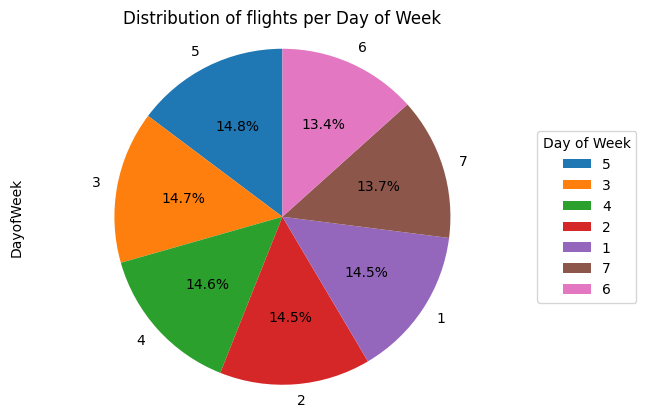

In [14]:
# Pie chart for the distribution of flights per Day of Week
# As we can see in the terms of persentages, while the distribution of flights are more or less the same
# among days 1-5, the quata on day 6 and 7 is reduced. So that means, that during weekends, people do not travel such much

day_of_week = data['DayofWeek'].value_counts()
day_of_week.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of flights per Day of Week')
plt.legend(title = "Day of Week",
          loc = "center left",
          bbox_to_anchor = (1, 0.5))

plt.show()

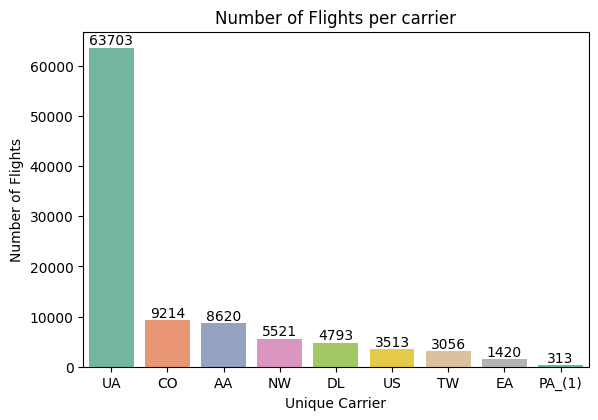

In [15]:
# visualize the count of flights for each unique carrier.
# As we can see, UA carier operates the most flights while PA(1) the less ones.

plt.figure(figsize=(30,20))
plt.subplot(4,4,1)
ax = sns.countplot(x = 'UniqueCarrier', palette='Set2', data = data, order = data['UniqueCarrier'].value_counts().index)
ax.bar_label(ax.containers[0])

plt.xlabel('Unique Carrier')
plt.title('Number of Flights per carrier')
plt.ylabel('Number of Flights')
plt.show()

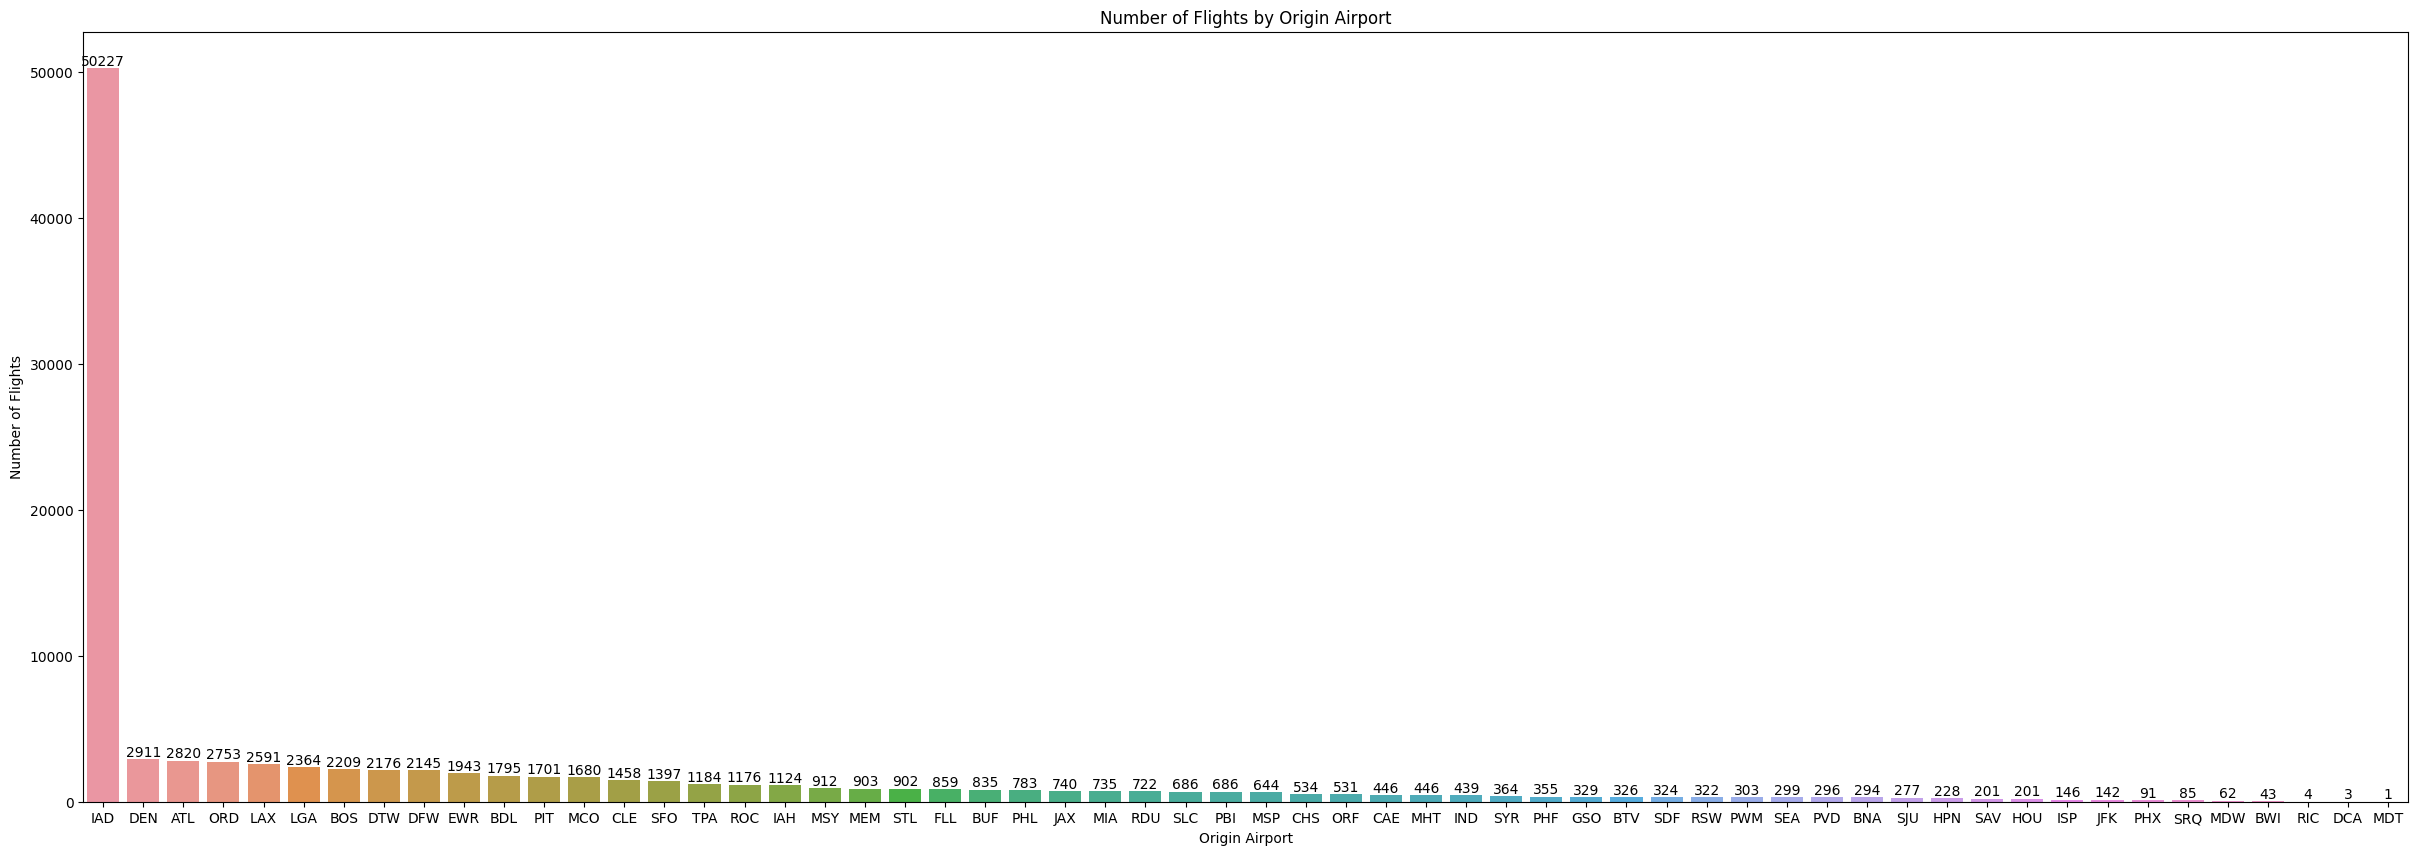

In [16]:
# Countplot for origin airport

plt.figure(figsize=(30,10))
ax = sns.countplot(x='Origin', data=data, order = data['Origin'].value_counts().index)
ax.bar_label(ax.containers[0])

plt.xlabel('Origin Airport')
plt.ylabel('Number of Flights')
plt.title('Number of Flights by Origin Airport')
plt.show()

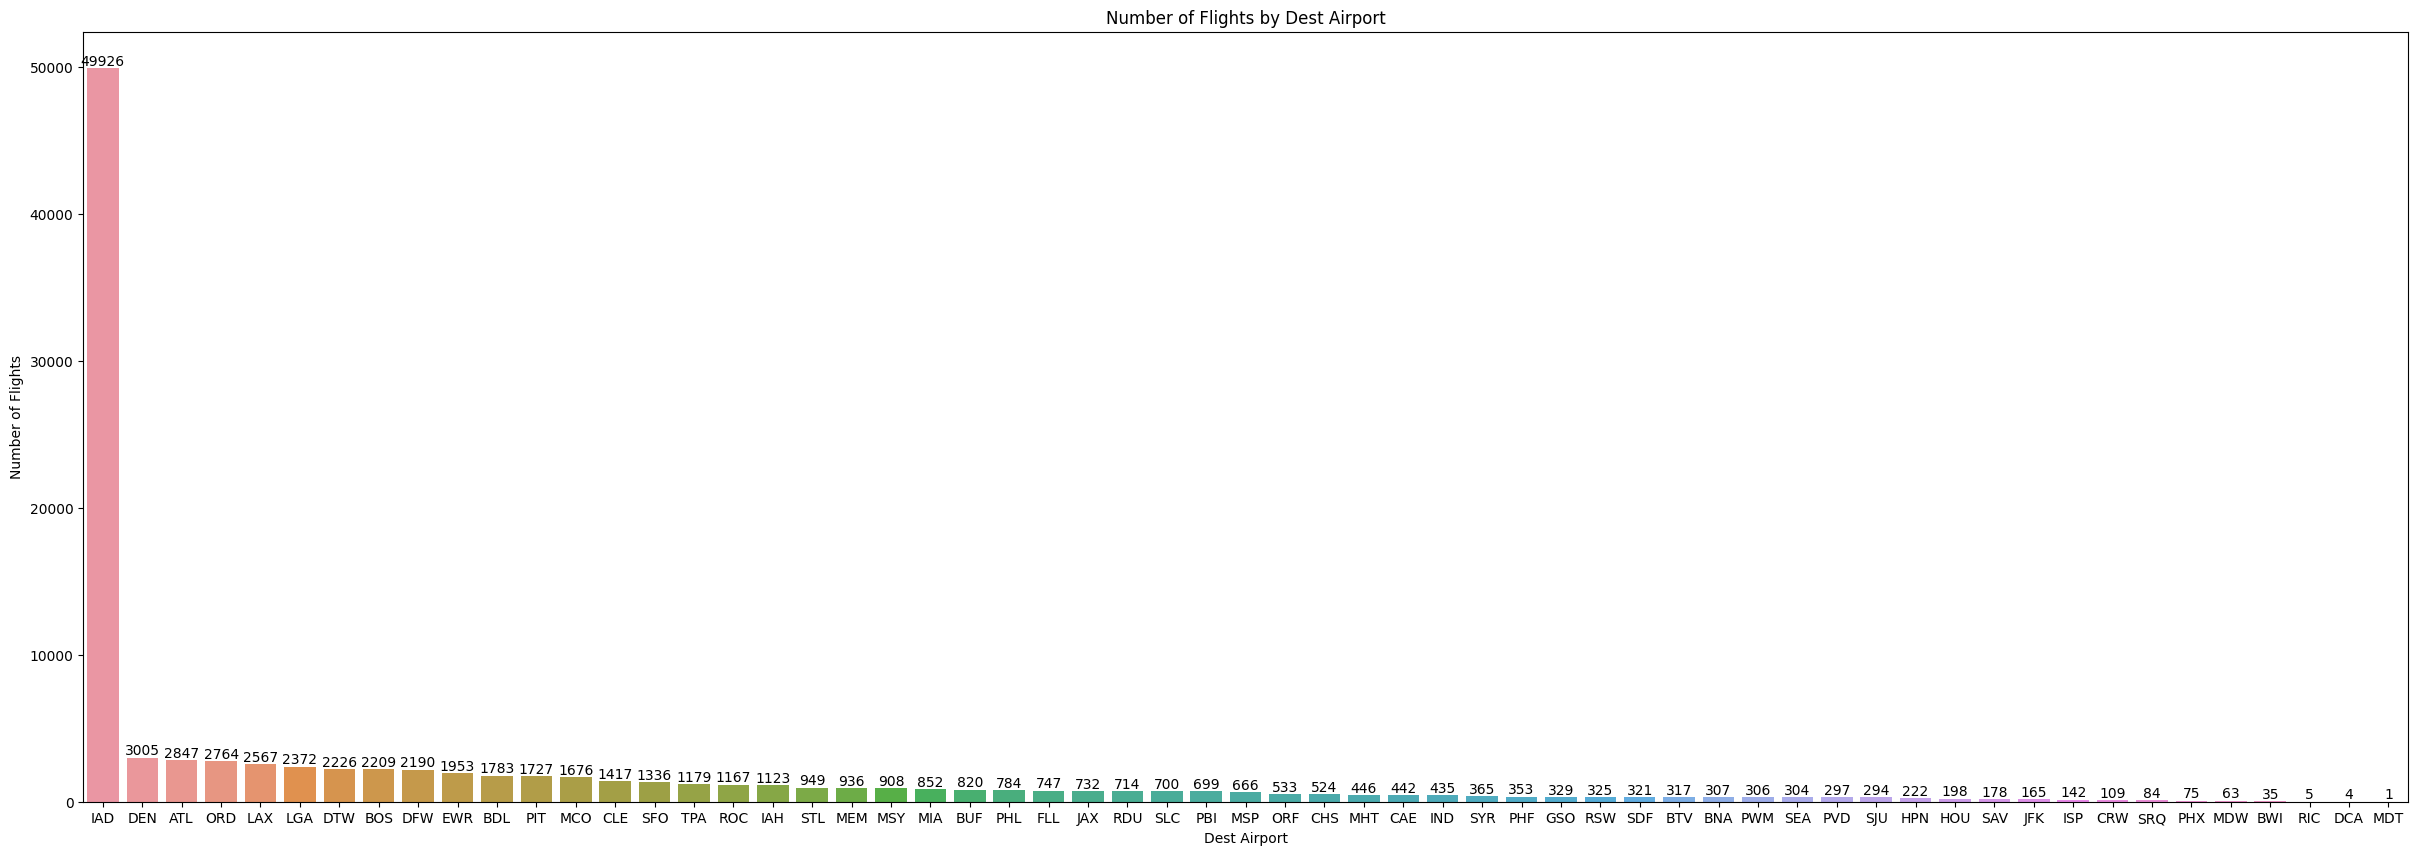

In [17]:
# Countplot for dest airport

plt.figure(figsize=(30,10))
ax = sns.countplot(x='Dest', data=data, order = data['Dest'].value_counts().index)
ax.bar_label(ax.containers[0])

plt.xlabel('Dest Airport')
plt.ylabel('Number of Flights')
plt.title('Number of Flights by Dest Airport')
plt.show()

##### Conclusions from the above 2 plots
As we can see,  IAD is the airport with the most flights either being as origin either being as destination airport. 
What is impressive, is that the distribution remains the same between origin and destination airports

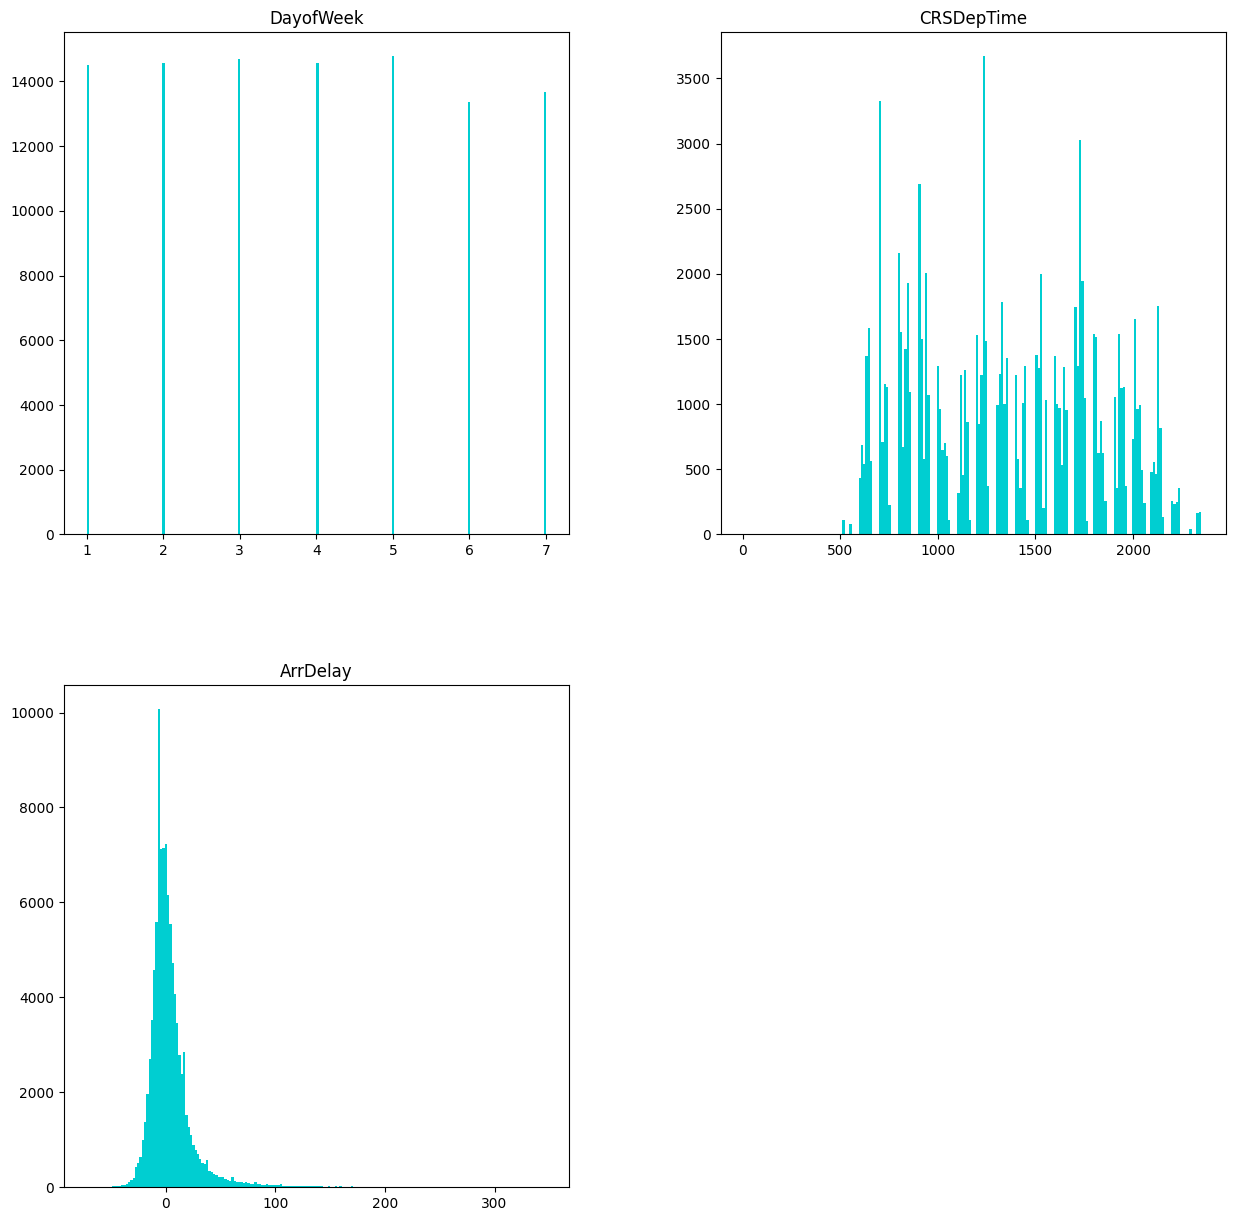

In [18]:
# shows distribution of each numerical feature
# As we can see
#   -there is high variation in the values of attribute CRSDepTime
#   -the values of ArrDealay are concentrated between [ -20, 20 ]  with median value 0

h = data.hist(figsize=(15, 15), color='darkturquoise', grid=False, bins=200)
plt.show()

<AxesSubplot: >

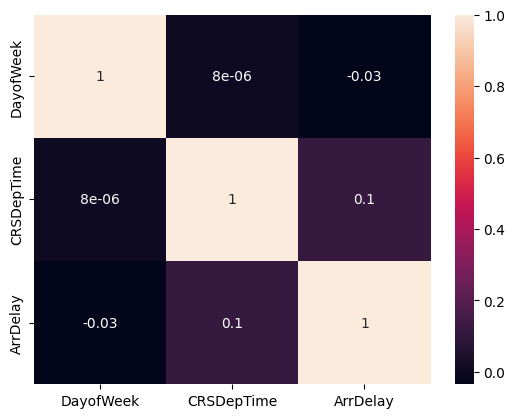

In [19]:
# correlation heatmap 
# As we can see, the attributes that are negatevely correlated are (CRSDeptTime - DayofWeek) & (ArrDelay - DayofWeek)

cancel_heatm = sns.heatmap(data.corr(method = 'pearson'), annot = True, fmt='.1g')  #format me 
cancel_heatm

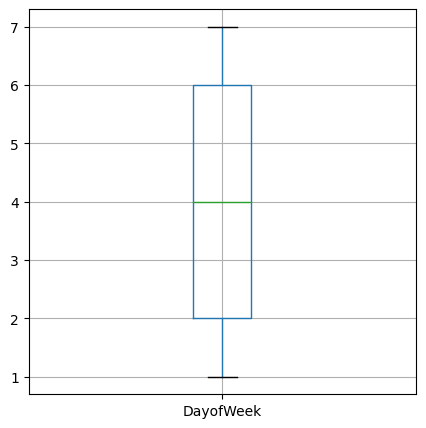

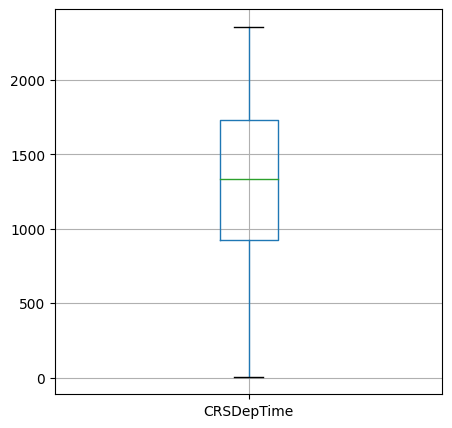

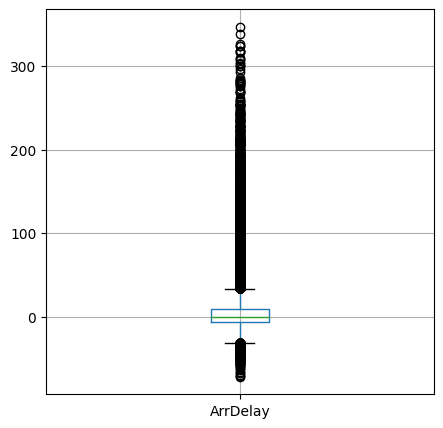

In [20]:
# create box plots for each non numeric feature

data_for_boxplots=data.copy()
data_for_boxplots=data_for_boxplots.select_dtypes(exclude=['object'])

for column in data_for_boxplots:
    plt.figure(figsize=(5,5))
    data_for_boxplots.boxplot([column])
    
    
# As we can see, Outliers exists mainly in ArrDealy attribute. However, we have already delete 5 rows and 
# we are afraid of losing important information if we delete more

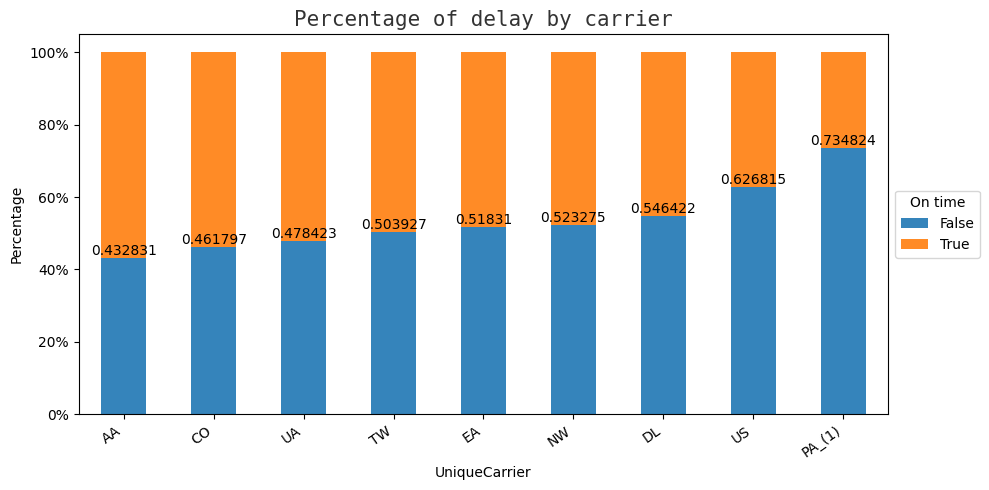

In [21]:
#plot of delay for each carrier (stacked barchart)

#data prep for plot
carier_delay_perc_plot = pd.DataFrame() #empty df
carier_delay_perc_plot['UniqueCarrier']=data['UniqueCarrier'] #carrier variable with full names
carier_delay_perc_plot['ArrDelay']=data['ArrDelay']<=0 #on time vs. delay
carier_delay_perc_plot = carier_delay_perc_plot.groupby(['UniqueCarrier',
                                                           'ArrDelay']).size().unstack(1) #shape and class data
carier_delay_perc_plot = carier_delay_perc_plot.div(carier_delay_perc_plot.sum(axis=1), axis=0) #percentage

#plot
f, ax = plt.subplots(figsize=(10, 5))
carier_delay_perc_plot.sort_values(by=False).plot(kind="bar", 
                                                  alpha=.9, stacked=True, ax=ax) #stacked bar plot

#set labels
ax.set_title("Percentage of delay by carrier",fontsize = 15, fontname="Monospace", alpha=.8) #title

plt.xlabel('UniqueCarrier', fontsize = 10) #xlabel
ax.set_xticklabels(ax.get_xticklabels(), rotation=35, ha="right") #rotate xlabel

plt.ylabel("Percentage", fontsize = 10) #ylabel
plt.legend(title = "On time", loc = "center left", bbox_to_anchor = (1, 0.5))

ax.bar_label(ax.containers[0]) #display values

plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) #yticks in percentage

plt.tight_layout(rect=[0, 0, 1, 1]) #tight rectangular layout

#plt.savefig('EDA_plot3.png', bbox_inches='tight') #save img

plt.show() #plot

True     51474
False    48679
Name: ArrDelay, dtype: int64


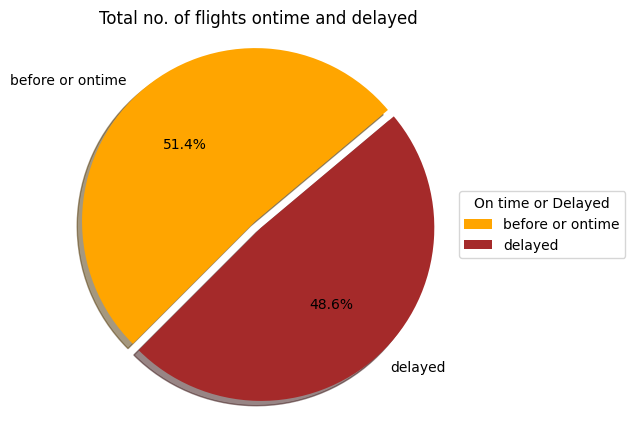

In [22]:
#pie chart to sum up the distribution delayed / not delayed flights

#total no. of flights ontime, and delayed
delay_perc = (data['ArrDelay']<=0) #true: before or ontime, false: delayed
print(delay_perc.value_counts()) #count



plt.figure(figsize=(5,5))
e = (0.05,0)
colors = ("orange", "brown")
labels=['before or ontime', 'delayed']

plt.pie(delay_perc.value_counts(), labels=labels, colors=colors,
         explode = e, autopct='%1.1f%%', shadow=True, startangle=40)

plt.axis('equal')
plt.title('Total no. of flights ontime and delayed')
plt.legend(title = "On time or Delayed",
          loc = "center left",
          bbox_to_anchor = (1, 0.5))


## Overview of task1

- The Attribute ArrDelay has outliers and we dropped the instances with Arrdelay > 350 (8 rows)
***
- According to the Attribute DayofWeek :

    - During the 3rd & 5th day, there are the most delays while on the 6th & 7th day the delays are fewer
    - In the terms of percentages, while the distribution of flights are more or less the same among days 1-5, the quota on day 6th and 7th is reduced. That means, that during weekends, people do not travel such much
***    
- According to the Attribute UniqueCarrier :

    - UA carier operates the most flights while PA(1) the less ones
***
- According to the Attributes Origin / Dest :

    - IAD is the airport with the most flights either being as origin either being as destination airport. What is impressive, is that the distribution remains the same between origin and destination airports



 


# Task2: Describe the average delays per airport/airline.

## Per Airline

In [23]:
# Group the data by UniqueCarrier and compute the average delay for each group

delays_per_carrier =pd.DataFrame(data.groupby('UniqueCarrier')['ArrDelay'].mean())
delays_per_carrier=delays_per_carrier.sort_values(by='ArrDelay', ascending=False)
delays_per_carrier

,ArrDelay
UniqueCarrier,
PA_(1),16.224
EA,11.728
US,6.247
TW,5.180
DL,5.119
NW,5.005
CO,4.684
UA,4.550
AA,1.908


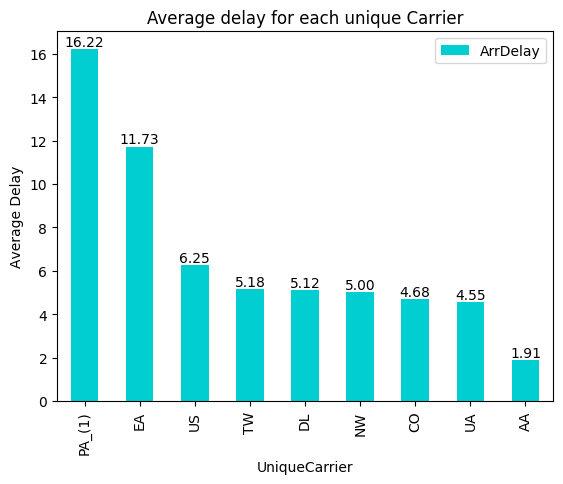

<Figure size 3000x500 with 0 Axes>

In [24]:
#  plot the average delay per Carrier


ax = delays_per_carrier.plot(kind='bar', color='darkturquoise', title='Average delay for each unique Carrier',)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.ylabel("Αverage Delay", fontsize = 10) #ylabel
plt.figure(figsize=(30,5))

plt.show()

## Per Airport

In [25]:
# Group the data by origin and compute the average delay for Origin airport

delays_per_origin =pd.DataFrame(data.groupby('Origin')['ArrDelay'].mean())
delays_per_origin=delays_per_origin.sort_values(by='ArrDelay', ascending=False)
delays_per_origin

,ArrDelay
Origin,
SJU,18.195
RIC,13.000
PVD,12.334
HPN,12.171
MDT,11.000
ORD,10.606
MHT,10.103
BOS,9.253
PWM,8.492


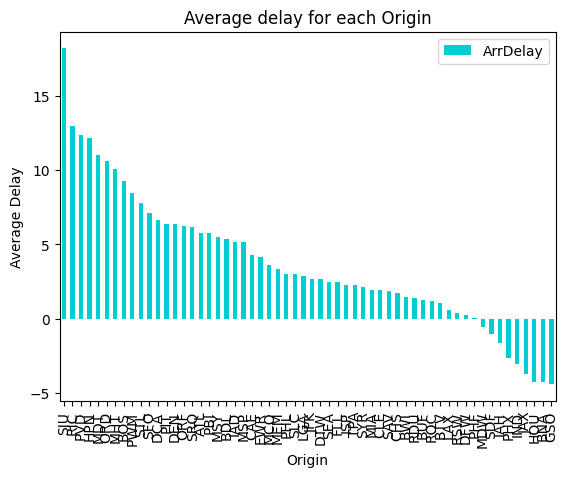

<Figure size 5000x500 with 0 Axes>

In [26]:
#  plot the average delay per Origin airport

delays_per_origin.plot(kind='bar', color='darkturquoise', title='Average delay for each Origin')
plt.ylabel("Average Delay", fontsize = 10) #ylabel
plt.figure(figsize=(50,5))
plt.show()


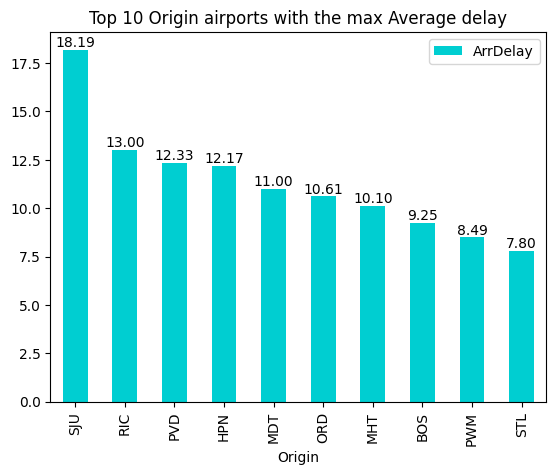

In [27]:
ax = delays_per_origin.head(10).plot(kind='bar', color='darkturquoise', 
                                title='Top 10 Origin airports with the max Average delay')
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.show()

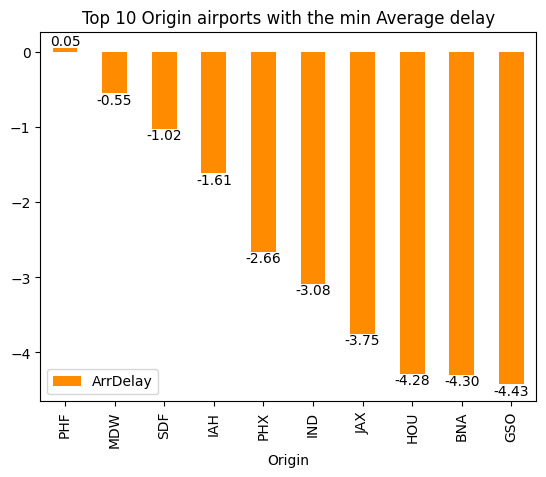

In [28]:
ax = delays_per_origin.tail(10).plot(kind='bar', color='darkorange',
                                title='Top 10 Origin airports with the min Average delay')

ax.bar_label(ax.containers[0], fmt='%.2f')
plt.show()

## Overview of task2

- According to Per Airline average Delays, we see :

    - PA_(1) is the first carrier which has 16.2 mean delay
    - EA is the second carrier which has 11.7 mean delay
    - the rest excpet AA have average delay between [ 6 - 4 ] mean delay
    - AA has 1.9 mean delay
 ***   
- According to Per (Origin) Airport average Delays, we see :

    - SJU is the first airport which has 18.2 mean delay
    - RIC is the second airport which has 13.0 mean delay
    - BNA & GSO are the airports where actually there is no delay as the mean delay is -4.3 respectively


# 3) Identify and report the most prominent rules of association between delays and point of origin AND/OR point of arrival.

In [29]:
# create a copy of the initial dataset

data_ar = data.copy()
data_ar

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay
0,5,600,UA,899.0,ORD,IAD,-3
1,5,615,DL,357.0,IAD,ATL,5
2,5,615,UA,341.0,IAD,DEN,8
3,5,625,CO,581.0,IAD,DEN,44
4,5,630,UA,902.0,CLE,IAD,-10
...,...,...,...,...,...,...,...
100156,6,2140,UA,30.0,LAX,IAD,-19
100157,6,2140,CO,896.0,LAX,IAD,-23
100158,6,2150,UA,1094.0,IAD,BDL,-14
100159,6,2155,US,394.0,PIT,IAD,9


In [30]:
# convert the below attributes to string

data_ar = data_ar.astype({"ArrDelay": str})
data_ar = data_ar.astype({"Origin": str})
data_ar = data_ar.astype({"Dest": str})

In [31]:
# Convert dataframe to list of lists
# data_ar = data_ar[['Origin', 'Dest', 'ArrDelay']].values.tolist()
# data_ar

data_ar = data_ar[['Origin', 'ArrDelay', 'Dest']].values.tolist()
data_ar

[['ORD', '-3', 'IAD'],
 ['IAD', '5', 'ATL'],
 ['IAD', '8', 'DEN'],
 ['IAD', '44', 'DEN'],
 ['CLE', '-10', 'IAD'],
 ['CLE', '-13', 'IAD'],
 ['EWR', '-12', 'IAD'],
 ['IAD', '1', 'RIC'],
 ['DTW', '-7', 'IAD'],
 ['BOS', '0', 'IAD'],
 ['LGA', '-12', 'IAD'],
 ['CAE', '-6', 'IAD'],
 ['BOS', '6', 'IAD'],
 ['IAD', '-12', 'LGA'],
 ['BDL', '-6', 'IAD'],
 ['IAD', '12', 'ATL'],
 ['ISP', '2', 'IAD'],
 ['IAD', '13', 'MSP'],
 ['TPA', '-10', 'IAD'],
 ['FLL', '-17', 'IAD'],
 ['RSW', '-18', 'IAD'],
 ['IAD', '16', 'ORD'],
 ['BUF', '-3', 'IAD'],
 ['FLL', '-13', 'IAD'],
 ['ROC', '-2', 'IAD'],
 ['IAD', '0', 'DTW'],
 ['MCO', '-4', 'IAD'],
 ['JAX', '-3', 'IAD'],
 ['PBI', '-19', 'IAD'],
 ['GSO', '0', 'IAD'],
 ['TPA', '9', 'IAD'],
 ['IAD', '-21', 'EWR'],
 ['IAD', '14', 'SLC'],
 ['IAH', '-24', 'IAD'],
 ['IAD', '0', 'PIT'],
 ['IAD', '1', 'ORD'],
 ['IAD', '-17', 'BOS'],
 ['DEN', '-28', 'IAD'],
 ['IAD', '-1', 'SJU'],
 ['IAD', '3', 'CLE'],
 ['CHS', '-4', 'IAD'],
 ['IAD', '17', 'DFW'],
 ['ORD', '1', 'IAD'],
 ['SFO', '

In [32]:
# 1st way of identifying Frequent itemset

from apyori import apriori

# Set the minimum support value
min_support = 0.003

# Run the Apriori algorithm
results = list(apriori(data_ar, min_support=min_support, max_length=3))

# Print the frequent itemsets 
for item in results:
    
    #print the triple frequent items
    if len(item[0]) == 3: 

        print("Frequent itemset: ",frozenset(item[0]), end=", ")
        print("Support: ",item[1])


Frequent itemset:  frozenset({'0', 'DTW', 'IAD'}), Support:  0.003035355905464639


In [33]:
# 2nd way of identifying Frequent itemset

from apriori_python import apriori

# Set the minimum support, confidence

# Run the Apriori algorithm

freqItemSet, rules = apriori(data_ar, minSup=0.003, minConf=0)
freqItemSet

{1: {frozenset({'-7'}),
  frozenset({'10'}),
  frozenset({'IAD'}),
  frozenset({'-6'}),
  frozenset({'12'}),
  frozenset({'CAE'}),
  frozenset({'CHS'}),
  frozenset({'-11'}),
  frozenset({'17'}),
  frozenset({'26'}),
  frozenset({'-15'}),
  frozenset({'ORD'}),
  frozenset({'-19'}),
  frozenset({'LGA'}),
  frozenset({'MCO'}),
  frozenset({'9'}),
  frozenset({'HPN'}),
  frozenset({'BOS'}),
  frozenset({'11'}),
  frozenset({'ROC'}),
  frozenset({'3'}),
  frozenset({'SAV'}),
  frozenset({'JAX'}),
  frozenset({'-21'}),
  frozenset({'SFO'}),
  frozenset({'DEN'}),
  frozenset({'PWM'}),
  frozenset({'15'}),
  frozenset({'-9'}),
  frozenset({'RSW'}),
  frozenset({'27'}),
  frozenset({'MHT'}),
  frozenset({'SDF'}),
  frozenset({'-18'}),
  frozenset({'DFW'}),
  frozenset({'SLC'}),
  frozenset({'20'}),
  frozenset({'HOU'}),
  frozenset({'13'}),
  frozenset({'TPA'}),
  frozenset({'EWR'}),
  frozenset({'6'}),
  frozenset({'1'}),
  frozenset({'BNA'}),
  frozenset({'RDU'}),
  frozenset({'BUF'}),
  fro

In [34]:
#print the rules

for rule in rules:
    print(f'{rule[0]} --> {rule[1]} [conf: {rule[2]}]')

{'IAD'} --> {'0', 'DTW'} [conf: 0.003035355905464639]
{'IAD'} --> {'31'} [conf: 0.003045340628837878]
{'IAD'} --> {'JFK'} [conf: 0.003065310075584356]
{'IAD'} --> {'-22'} [conf: 0.003434744840394197]
{'IAD'} --> {'29'} [conf: 0.0034447295637674356]
{'IAD'} --> {'30'} [conf: 0.003614469861112498]
{'IAD'} --> {'SAV'} [conf: 0.00378421015845756]
{'IAD'} --> {'28'} [conf: 0.003834133775323755]
{'IAD'} --> {'HOU'} [conf: 0.003983904625922339]
{'IAD'} --> {'27'} [conf: 0.004043812966161773]
{'IAD'} --> {'26'} [conf: 0.004403263007598374]
{'IAD'} --> {'HPN'} [conf: 0.004493125517957525]
{'IAD'} --> {'25'} [conf: 0.004563018581570198]
{'IAD'} --> {'-21'} [conf: 0.004582988028316676]
{'IAD'} --> {'24'} [conf: 0.005321857557936357]
{'IAD'} --> {'-20'} [conf: 0.005401735344922269]
{'IAD'} --> {'23'} [conf: 0.005651353429253243]
{'IAD'} --> {'SJU'} [conf: 0.0057012770461194375]
{'IAD'} --> {'PVD'} [conf: 0.005920940960330694]
{'IAD'} --> {'BNA'} [conf: 0.006000818747316606]
{'IAD'} --> {'SEA'} [co

In [35]:
from mlxtend.frequent_patterns import apriori

dataset = data_ar
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.003, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets
frequent_itemsets

,support,itemsets,length
0,0.035,(-1),1
1,0.024,(-10),1
2,0.021,(-11),1
3,0.019,(-12),1
4,0.016,(-13),1
...,...,...,...
204,0.014,"(SLC, IAD)",2
205,0.018,"(STL, IAD)",2
206,0.007,"(SYR, IAD)",2
207,0.024,"(TPA, IAD)",2


In [36]:
assoc_rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.003)

# create a column with the lenght of the antecedents so as to be easier to dive in the association rules 
assoc_rules["antecedent_len"] = assoc_rules["antecedents"].apply(lambda x: len(x))
assoc_rules.insert(8, 'antecedent_len', assoc_rules.pop('antecedent_len')) 

assoc_rules = assoc_rules.iloc[:, 0:9]


assoc_rules = assoc_rules[assoc_rules['antecedent_len'] == 1]

assoc_rules.sort_values(['confidence', 'support'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,antecedent_len
128,(DEN),(IAD),0.059,1.000,0.059,1.000,1.000,0.000,1
110,(ATL),(IAD),0.057,1.000,0.057,1.000,1.000,0.000,1
168,(ORD),(IAD),0.055,1.000,0.055,1.000,1.000,0.000,1
152,(LAX),(IAD),0.052,1.000,0.052,1.000,1.000,0.000,1
154,(LGA),(IAD),0.047,1.000,0.047,1.000,1.000,0.000,1
...,...,...,...,...,...,...,...,...,...
91,(IAD),(29),1.000,0.003,0.003,0.003,1.000,0.000,1
29,(IAD),(-22),1.000,0.003,0.003,0.003,1.000,0.000,1
151,(IAD),(JFK),1.000,0.003,0.003,0.003,1.000,0.000,1
97,(IAD),(31),1.000,0.003,0.003,0.003,1.000,0.000,1


In [37]:
assoc_rules.shape

(211, 9)

## Overview of task3

- Setting the min_support=0.003 and antecedent_len == 2,  we were able to identify just one itemset with length = 3. 

This frequent itemset is : frozenset({'IAD', 'DTW', '0'}), Support:  0.003

    - (DTW, 0) --->	(IAD)	support : 0.003	confidence / lift : 1.000
    - (0, IAD) --->	(DTW)	support : 0.003	confidence : 0.076  lift : 1.720
    - (DTW, IAD) ---> (0)	support : 0.003	confidence : 0.069  lift : 1.720
***


- Sorting the assoc_rules table by ['confidence', 'support'] we were able to identify in total 211 rules. Most of them were between origin / dest airports. 
***


- However, because we are entitled to deliver the most prominent rules of association between delays and point of origin AND/OR point of arrival we will ignore the association rules between airports and we will keep those with airport / delay.
***


- Moreover, we identfied rules between delays and IAD or IAD and delays. For this reason, we decided to display the first (based on the sorting table by confidence and late by support) 4 association rules between ArrDelay --> IAD & the first 4 association rules between IAD --> ArrDelay
***


    - (0) --->	(IAD)	support : 0.040	confidence : 1.000 lift : 1.000
    - (-2) --->	(IAD)	support : 0.037	confidence : 1.000  lift : 1.000
    - (-3) --->	(IAD)	support : 0.037	confidence : 1.000  lift : 1.000
    - (-5) --->	(IAD)	support : 0.036	confidence : 1.000  lift : 1.000
    - (IAD) ---> (0)	support : 0.040	confidence : 0.040  lift : 1.000
    - (IAD) ---> (-2)	support : 0.037	confidence : 0.037  lift : 1.000
    - (IAD) ---> (-3)	support : 0.037	confidence : 0.037  lift : 1.000
    - (IAD) ---> (-5)	support : 0.036	confidence : 0.036  lift : 1.000



# 4) Try to predict the delay given all other features and report the appropriate performance on cross-validation.

In [38]:
# create a copy of the initial dataset

data_predictions=data.copy()
data_predictions

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay
0,5,600,UA,899.0,ORD,IAD,-3
1,5,615,DL,357.0,IAD,ATL,5
2,5,615,UA,341.0,IAD,DEN,8
3,5,625,CO,581.0,IAD,DEN,44
4,5,630,UA,902.0,CLE,IAD,-10
...,...,...,...,...,...,...,...
100156,6,2140,UA,30.0,LAX,IAD,-19
100157,6,2140,CO,896.0,LAX,IAD,-23
100158,6,2150,UA,1094.0,IAD,BDL,-14
100159,6,2155,US,394.0,PIT,IAD,9


In [39]:
#manipulating the origin form str to int

data_predictions.Origin = data_predictions.Origin.map({
"ORD":1,"IAD":2,"CLE":3,"EWR":4,"DTW":5,"BOS":6,"LGA":7,"CAE":8,"BDL":9,"ISP":10,
"TPA":11,"FLL":12,"RSW":13,"BUF":14,"ROC":15,"MCO":16,"JAX":17,"PBI":18,"GSO":19,
"IAH":20,"DEN":21,"CHS":22,"SFO":23,"DFW":24,"LAX":25,"RDU":26,"PIT":27,"SLC":28,
"JFK":29,"ATL":30,"PHF":31,"MSY":32,"MDW":33,"MIA":34,"MEM":35,"STL":36,"ORF":37,
"SJU":38,"RIC":39,"DCA":40,"SEA":41,"MSP":42,"PHL":43,"MDT":44,"HPN":45,"BWI":46,
"SRQ":47,"MHT":48,"SYR":49,"SDF":50,"BTV":51,"IND":52,"BNA":53,"HOU":54,"SAV":55,
"PVD":56,"PWM":57,"PHX":58})

data_predictions.Dest = data_predictions.Dest.map({
"ORD":1,"IAD":2,"CLE":3,"EWR":4,"DTW":5,"BOS":6,"LGA":7,"CAE":8,"BDL":9,"ISP":10,
"TPA":11,"FLL":12,"RSW":13,"BUF":14,"ROC":15,"MCO":16,"JAX":17,"PBI":18,"GSO":19,
"IAH":20,"DEN":21,"CHS":22,"SFO":23,"DFW":24,"LAX":25,"RDU":26,"PIT":27,"SLC":28,
"JFK":29,"ATL":30,"PHF":31,"MSY":32,"MDW":33,"MIA":34,"MEM":35,"STL":36,"ORF":37,
"SJU":38,"RIC":39,"DCA":40,"SEA":41,"MSP":42,"PHL":43,"MDT":44,"HPN":45,"BWI":46,
"SRQ":47,"MHT":48,"SYR":49,"SDF":50,"BTV":51,"IND":52,"BNA":53,"HOU":54,"SAV":55,
"PVD":56,"PWM":57,"PHX":58, "CRW":59})

data_predictions.UniqueCarrier = data_predictions.UniqueCarrier.map({
"UA":1,"DL":2,"CO":3,"EA":4,"NW":5,"AA":6,"US":7,"TW":8,"PA_(1)":9})

data_predictions

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay
0,5,600,1,899.0,1,2,-3
1,5,615,2,357.0,2,30,5
2,5,615,1,341.0,2,21,8
3,5,625,3,581.0,2,21,44
4,5,630,1,902.0,3,2,-10
...,...,...,...,...,...,...,...
100156,6,2140,1,30.0,25,2,-19
100157,6,2140,3,896.0,25,2,-23
100158,6,2150,1,1094.0,2,9,-14
100159,6,2155,7,394.0,27,2,9


In [40]:
# transform the flight number from object to int

data_predictions['FlightNum'] = data_predictions['FlightNum'].astype('float').apply(np.int64)

In [41]:
data_predictions.dtypes

DayofWeek        int32
CRSDepTime       int32
UniqueCarrier    int64
FlightNum        int64
Origin           int64
Dest             int64
ArrDelay         int32
dtype: object

In [42]:
# initialise the regression models

Las = Lasso(random_state=2 , alpha=0.1)
LinR = LinearRegression()
Rid = Ridge(random_state=2)
Rfc = RandomForestRegressor(random_state=2)
Dtc = DecisionTreeRegressor(random_state = 2)
Boost_Lin = AdaBoostRegressor(base_estimator=LinR,random_state=2)
Boost_las = AdaBoostRegressor(base_estimator=Las,random_state=2)
Boost_rid = AdaBoostRegressor(base_estimator=Rid,random_state=2)
Bg_Lin = BaggingRegressor(base_estimator=LinR,random_state=2)
Bg_las = BaggingRegressor(base_estimator=Las,random_state=2)
Bg_rid = BaggingRegressor(base_estimator=Rid,random_state=2)
xgb = XGBRegressor(random_state=2)
gb = GradientBoostingRegressor(random_state=2)


In [43]:
# split the data into Train / split

X = data_predictions[['CRSDepTime', 'UniqueCarrier', 'FlightNum' ,'Origin', 'Dest']]

y = data_predictions['ArrDelay']
# Splitting into train and test data set

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 2)

In [44]:
# run the models and print the scores

for model, name in zip([Las,LinR,Rid,Dtc,Rfc,Boost_Lin,Boost_las,Boost_rid,Bg_Lin,Bg_las,Bg_rid, xgb, gb], 
     ['Lasso','Linear Regression','Ridge','Random forest Regressor','Decision Tree Regressor','Boosted Linear',
      'Boosted Lasso','Boosted Ridge','Bagged Linear','Bagged Lasso','Bagged Ridge', 'XGBRegressor',
      'GradientBoostingRegressor']):
    
    model1 = model.fit(X_train,y_train)
    Y_predict=model1.predict(X_test)
    
    print(name)
    print('Mean Absolute Error: {:.4f}'.format(mean_absolute_error(y_test, Y_predict)))
    print('Mean Squared Error: {:.4f}'.format(mean_squared_error(y_test, Y_predict)))
    print('Root Mean Squared Error: {:.4f}'.format(np.sqrt(mean_squared_error(y_test, Y_predict))))
    print('R2: {:.4f}'.format(r2_score(y_test, Y_predict)))
    print()


Lasso
Mean Absolute Error: 13.4569
Mean Squared Error: 502.2130
Root Mean Squared Error: 22.4101
R2: 0.0158

Linear Regression
Mean Absolute Error: 13.4587
Mean Squared Error: 502.2185
Root Mean Squared Error: 22.4102
R2: 0.0158

Ridge
Mean Absolute Error: 13.4587
Mean Squared Error: 502.2185
Root Mean Squared Error: 22.4102
R2: 0.0158

Random forest Regressor
Mean Absolute Error: 12.4310
Mean Squared Error: 459.2611
Root Mean Squared Error: 21.4304
R2: 0.1000

Decision Tree Regressor
Mean Absolute Error: 12.4335
Mean Squared Error: 458.9529
Root Mean Squared Error: 21.4232
R2: 0.1006

Boosted Linear
Mean Absolute Error: 16.3916
Mean Squared Error: 554.7013
Root Mean Squared Error: 23.5521
R2: -0.0871

Boosted Lasso
Mean Absolute Error: 16.3271
Mean Squared Error: 552.8683
Root Mean Squared Error: 23.5132
R2: -0.0835

Boosted Ridge
Mean Absolute Error: 16.3332
Mean Squared Error: 553.0887
Root Mean Squared Error: 23.5178
R2: -0.0839

Bagged Linear
Mean Absolute Error: 13.4636
Mean Squa

To help us choose:

- MAE: Lower values are better, and a value of 0 indicates a perfect fit.
- MSE: Lower values are better, and a value of 0 indicates a perfect fit.
- RMSE: Lower values are better, and a value of 0 indicates a perfect fit.
- R2 : R2 score ranges between 0 and 1, higher value indicates better fit.

Random forest Regressor
- Mean Absolute Error: 12.4310
- Mean Squared Error: 459.2611
- Root Mean Squared Error: 21.4304
- R2: 0.1000
***
Decision Tree Regressor
- Mean Absolute Error: 12.4335
- Mean Squared Error: 458.9529
- Root Mean Squared Error: 21.4232
- R2: 0.1006

***
XGBRegressor
- Mean Absolute Error: 12.4127
- Mean Squared Error: 456.6178
- Root Mean Squared Error: 21.3686
- R2: 0.1052
***
So, before checking the performance of each model, we will see the feature importance plot for the winner mode: XGBRegressor


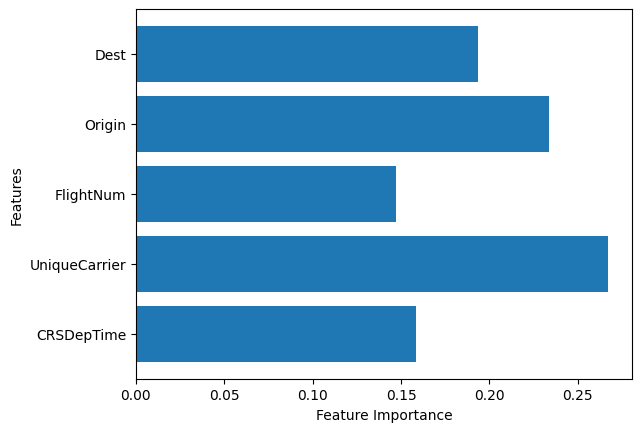

In [45]:
# Train a XGBRegressor 

xgb = XGBRegressor(random_state=2)
xgb.fit(X_train, y_train)

# Get the feature importance values
feature_importance = xgb.feature_importances_

# Create a bar chart of feature importance values
plt.barh(X_train.columns, feature_importance)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

# # summarize feature importance
# for i,v in enumerate(importance):
#  print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# pyplot.bar([x for x in range(len(importance))], importance)
# pyplot.show()

#### We select the 2 best models for the above results to see their performance on cross validation with k = 30

Cross validation for XGBRegressor

In [46]:
# Perform cross-validation and predict the delay
y_pred_xgb = cross_val_predict(xgb, X, y, cv=30)

# Calculate the mean squared error
mse = mean_squared_error(y, y_pred_xgb)

# Calculate the r2
r2=r2_score(y, y_pred_xgb)

# Display the predicted delay
print("Predicted Delay: ", y_pred_xgb)

# Print the mean squared error
print("Mean Squared Error: ","{:.6}".format(mse))

# Print r2
print("R2: ","{:.4}".format(r2))

Predicted Delay:  [ 3.546653    7.497136    0.5006693  ... -0.55629456  0.8690557
  7.3832035 ]
Mean Squared Error:  487.881
R2:  0.08275


Cross validation for Decision Tree Regressor

In [47]:
# Perform cross-validation and predict the delay
y_pred_Dtc= cross_val_predict(Dtc, X, y, cv=30)

# Calculate the mean squared error
mse = mean_squared_error(y, y_pred_Dtc)

# Calculate the r2
r2=r2_score(y, y_pred_Dtc)

# Display the predicted delay
print("Predicted Delay: ", y_pred_Dtc)

# Print the mean squared error
print("Mean Squared Error: ","{:.6}".format(mse))

# Print r2
print("R2: ","{:.4}".format(r2))

Predicted Delay:  [ 4.42056075  8.52173913  0.57692308 ... -2.4        -0.08510638
  7.43731778]
Mean Squared Error:  493.736
R2:  0.07174


Again, XGB provides the best results among them so we select this regressor for our model even if $R^2$ is pretty low

In [48]:
#display the predicted delay (y_pred) along with the rest of the dataset

data_predictions['Predicted_Delay'] = y_pred_xgb
data_predictions

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay,Predicted_Delay
0,5,600,1,899,1,2,-3,3.547
1,5,615,2,357,2,30,5,7.497
2,5,615,1,341,2,21,8,0.501
3,5,625,3,581,2,21,44,9.835
4,5,630,1,902,3,2,-10,-3.923
...,...,...,...,...,...,...,...,...
100156,6,2140,1,30,25,2,-19,-4.212
100157,6,2140,3,896,25,2,-23,4.378
100158,6,2150,1,1094,2,9,-14,-0.556
100159,6,2155,7,394,27,2,9,0.869


#### Hyperparameter tuning for XGBRegressor

In [49]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Create the XGBRegressor model
xgb = XGBRegressor(random_state=2)

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(grid_search.best_params_)


{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [50]:
# Make predictions on new data

xgb = XGBRegressor(random_state=2, learning_rate= 0.1, max_depth=7, n_estimators= 200 )

xgb.fit(X_train,y_train)
Y_predict=xgb.predict(X_test)
    
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, Y_predict)
mse = mean_squared_error(y_test, Y_predict)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, Y_predict)

# Print evaluation metrics
print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')


MAE: 12.41
MSE: 456.59
RMSE: 21.37
R2: 0.11


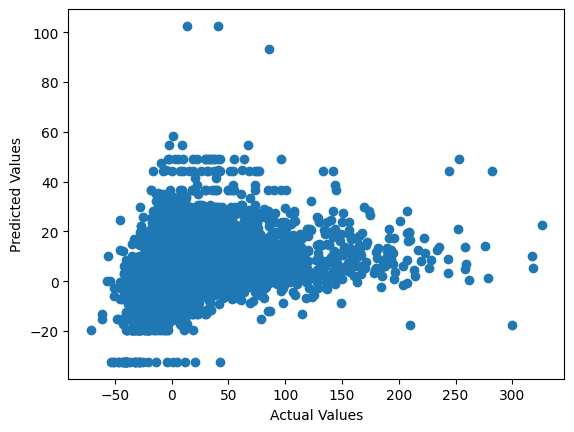

In [51]:
# create a scatter plot of the predicted values against the actual values

plt.scatter(y_test, Y_predict)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

## Predict the delay given all other features with multiclass classification.
We've run the below code for 1h and still was running. So, we interrupted the kernel and we put it into comments just to mention that we tried to execute also a multi classification problem.

In [54]:
# from sklearn.svm import SVC
# from sklearn.multiclass import OneVsRestClassifier


# # Define the bins and labels for the bins
# bins = [-float("inf"), -15, 0, 15, float("inf")]
# labels = ['Early', 'On-time', 'Slightly Delayed', 'Delayed']

# # Bin the ArrDelay values
# y_binned = pd.cut(y, bins=bins, labels=labels)

# from sklearn.preprocessing import LabelEncoder

# # Encode class values as integers
# encoder = LabelEncoder()
# y_encoded = encoder.fit_transform(y_binned)

In [55]:
# # Divide the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=2)

# # Create the SVM classifier
# clf = SVC(kernel='linear', C=1)

# # Using One Vs Rest strategy
# clf = OneVsRestClassifier(clf)

# # Fit the classifier to the training data
# clf.fit(X_train, y_train)


## Overview of task4

- As the task was about to predict the delay, we've run 13 Regression models
***

- The 3 best of them according to $R^2$ were :
    - Random forest Regressor
        - Mean Absolute Error: 12.4743
        - Mean Squared Error: 464.9803
        - Root Mean Squared Error: 21.5634
        - $R^2$: 0.0955
        
    - Decision Tree Regressor
        - Mean Absolute Error: 12.4696
        - Mean Squared Error: 463.6157
        - Root Mean Squared Error: 21.5317
        - $R^2$: 0.0981
        
    - XGBRegressor
        - Mean Absolute Error: 12.4343
        - Mean Squared Error: 461.4866
        - Root Mean Squared Error: 21.4822
        - $R^2$: 0.1023
***  
- Evaluating the performance of Decision Tree Regressor and XGBRegressor on cross-validation :

    - XGBRegressor --> $R^2$ = 0.08275
    - Decision Tree Regressor --> $R^2$ = 0.07174

***
So, XGBRegressor is the winner even if the $R^2$ is not ideal.

***
Finally, we tried to run a multiclassification model but SVC was running for 1 hour so we decided to stop the kernel and just comment in the code


# 5) Identify patterns/rules regarding delays and try to explain when delays should be expected, based on these patterns.

In [68]:
data_rules = data_predictions.copy()

data_rules.Origin = data_rules.Origin.map({
1:"ORD",2:"IAD",3:"CLE",4:"EWR",5:"DTW",6:"BOS",7:"LGA",8:"CAE",9:"BDL",10:"ISP",
11:"TPA",12:"FLL",13:"RSW",14:"BUF",15:"ROC",16:"MCO",17:"JAX",18:"PBI",19:"GSO",
20:"IAH",21:"DEN",22:"CHS",23:"SFO",24:"DFW",25:"LAX",26:"RDU",27:"PIT",28:"SLC",
29:"JFK",30:"ATL",31:"PHF",32:"MSY",33:"MDW",34:"MIA",35:"MEM",36:"STL",37:"ORF",
38:"SJU",39:"RIC",40:"DCA",41:"SEA",42:"MSP",43:"PHL",44:"MDT",45:"HPN",46:"BWI",
47:"SRQ",48:"MHT",49:"SYR",50:"SDF",51:"BTV",52:"IND",53:"BNA",54:"HOU",55:"SAV",
56:"PVD",57:"PWM",58:"PHX"})

data_rules.Dest = data_rules.Dest.map({
1:"ORD",2:"IAD",3:"CLE",4:"EWR",5:"DTW",6:"BOS",7:"LGA",8:"CAE",9:"BDL",10:"ISP",
11:"TPA",12:"FLL",13:"RSW",14:"BUF",15:"ROC",16:"MCO",17:"JAX",18:"PBI",19:"GSO",
20:"IAH",21:"DEN",22:"CHS",23:"SFO",24:"DFW",25:"LAX",26:"RDU",27:"PIT",28:"SLC",
29:"JFK",30:"ATL",31:"PHF",32:"MSY",33:"MDW",34:"MIA",35:"MEM",36:"STL",37:"ORF",
38:"SJU",39:"RIC",40:"DCA",41:"SEA",42:"MSP",43:"PHL",44:"MDT",45:"HPN",46:"BWI",
47:"SRQ",48:"MHT",49:"SYR",50:"SDF",51:"BTV",52:"IND",53:"BNA",54:"HOU",55:"SAV",
56:"PVD",57:"PWM",58:"PHX",59:"CRW"})

data_rules.UniqueCarrier = data_rules.UniqueCarrier.map({
1:"UA",2:"DL",3:"CO",4:"EA",5:"NW",6:"AA",7:"US",8:"TW",9:"PA_(1)"})


In [70]:
data_rules=data_rules.astype({"Predicted_Delay": int})

In [71]:
data_rules

,DayofWeek,CRSDepTime,UniqueCarrier,FlightNum,Origin,Dest,ArrDelay,Predicted_Delay
0,5,600,UA,899,ORD,IAD,-3,3
1,5,615,DL,357,IAD,ATL,5,7
2,5,615,UA,341,IAD,DEN,8,0
3,5,625,CO,581,IAD,DEN,44,9
4,5,630,UA,902,CLE,IAD,-10,-3
...,...,...,...,...,...,...,...,...
100156,6,2140,UA,30,LAX,IAD,-19,-4
100157,6,2140,CO,896,LAX,IAD,-23,4
100158,6,2150,UA,1094,IAD,BDL,-14,0
100159,6,2155,US,394,PIT,IAD,9,0


In [72]:
data_rules = data_rules.astype({"Predicted_Delay": str})
data_rules = data_rules.astype({"Origin": str})
data_rules = data_rules.astype({"Dest": str})

In [73]:
data_rules = data_rules[['Origin', 'Predicted_Delay', 'Dest']].values.tolist()
data_rules

[['ORD', '3', 'IAD'],
 ['IAD', '7', 'ATL'],
 ['IAD', '0', 'DEN'],
 ['IAD', '9', 'DEN'],
 ['CLE', '-3', 'IAD'],
 ['CLE', '0', 'IAD'],
 ['EWR', '-12', 'IAD'],
 ['IAD', '4', 'RIC'],
 ['DTW', '-2', 'IAD'],
 ['BOS', '5', 'IAD'],
 ['LGA', '-6', 'IAD'],
 ['CAE', '1', 'IAD'],
 ['BOS', '8', 'IAD'],
 ['IAD', '0', 'LGA'],
 ['BDL', '2', 'IAD'],
 ['IAD', '0', 'ATL'],
 ['ISP', '4', 'IAD'],
 ['IAD', '3', 'MSP'],
 ['TPA', '0', 'IAD'],
 ['FLL', '0', 'IAD'],
 ['RSW', '0', 'IAD'],
 ['IAD', '4', 'ORD'],
 ['BUF', '0', 'IAD'],
 ['FLL', '-2', 'IAD'],
 ['ROC', '7', 'IAD'],
 ['IAD', '7', 'DTW'],
 ['MCO', '1', 'IAD'],
 ['JAX', '0', 'IAD'],
 ['PBI', '5', 'IAD'],
 ['GSO', '-5', 'IAD'],
 ['TPA', '-2', 'IAD'],
 ['IAD', '6', 'EWR'],
 ['IAD', '5', 'SLC'],
 ['IAH', '-6', 'IAD'],
 ['IAD', '5', 'PIT'],
 ['IAD', '-1', 'ORD'],
 ['IAD', '2', 'BOS'],
 ['DEN', '-3', 'IAD'],
 ['IAD', '10', 'SJU'],
 ['IAD', '0', 'CLE'],
 ['CHS', '-1', 'IAD'],
 ['IAD', '8', 'DFW'],
 ['ORD', '0', 'IAD'],
 ['SFO', '3', 'IAD'],
 ['IAD', '1', 'LGA'

In [74]:
from apriori_python import apriori

# Set the minimum support, confidence

# Run the Apriori algorithm

freqItemSet, rules = apriori(data_rules, minSup=0.003, minConf=0)
freqItemSet

{1: {frozenset({'-7'}),
  frozenset({'10'}),
  frozenset({'IAD'}),
  frozenset({'-6'}),
  frozenset({'12'}),
  frozenset({'CAE'}),
  frozenset({'CHS'}),
  frozenset({'-11'}),
  frozenset({'17'}),
  frozenset({'ORD'}),
  frozenset({'LGA'}),
  frozenset({'MCO'}),
  frozenset({'9'}),
  frozenset({'HPN'}),
  frozenset({'BOS'}),
  frozenset({'11'}),
  frozenset({'3'}),
  frozenset({'ROC'}),
  frozenset({'SAV'}),
  frozenset({'JAX'}),
  frozenset({'SFO'}),
  frozenset({'DEN'}),
  frozenset({'PWM'}),
  frozenset({'15'}),
  frozenset({'-9'}),
  frozenset({'RSW'}),
  frozenset({'MHT'}),
  frozenset({'SDF'}),
  frozenset({'DFW'}),
  frozenset({'SLC'}),
  frozenset({'20'}),
  frozenset({'HOU'}),
  frozenset({'13'}),
  frozenset({'TPA'}),
  frozenset({'EWR'}),
  frozenset({'6'}),
  frozenset({'1'}),
  frozenset({'BNA'}),
  frozenset({'BUF'}),
  frozenset({'RDU'}),
  frozenset({'MSY'}),
  frozenset({'MSP'}),
  frozenset({'GSO'}),
  frozenset({'19'}),
  frozenset({'PHF'}),
  frozenset({'-5'}),
  fro

In [75]:
# Print rules
for rule in rules:
    print(f'{rule[0]} --> {rule[1]} [conf: {rule[2]}]')

{'IAD'} --> {'21'} [conf: 0.003005401735344922]
{'IAD'} --> {'JFK'} [conf: 0.003065310075584356]
{'IAD'} --> {'DTW', '2'} [conf: 0.0031052489690773116]
{'IAD'} --> {'23'} [conf: 0.0031152336924505507]
{'IAD'} --> {'6', 'DEN'} [conf: 0.0031651573093167454]
{'IAD'} --> {'15', 'ORD'} [conf: 0.0031651573093167454]
{'IAD'} --> {'BDL', '5'} [conf: 0.0031651573093167454]
{'IAD'} --> {'6', 'BDL'} [conf: 0.003235050372929418]
{'IAD'} --> {'-4', 'LAX'} [conf: 0.003245035096302657]
{'IAD'} --> {'4', 'ORD'} [conf: 0.003265004543049135]
{'IAD'} --> {'0', 'DTW'} [conf: 0.003294958713168852]
{'IAD'} --> {'9', 'PIT'} [conf: 0.0033548670534082853]
{'IAD'} --> {'DTW', '3'} [conf: 0.003384821223528002]
{'IAD'} --> {'ROC', '1'} [conf: 0.0033948059469012413]
{'IAD'} --> {'PIT', '8'} [conf: 0.003414775393647719]
{'IAD'} --> {'7', 'DTW'} [conf: 0.0034547142871406747]
{'IAD'} --> {'2', 'BDL'} [conf: 0.0034547142871406747]
{'IAD'} --> {'DFW', '4'} [conf: 0.0034946531806336304]
{'IAD'} --> {'3', 'DEN'} [conf: 0

In [76]:
from mlxtend.frequent_patterns import apriori

dataset = data_rules
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
frequent_itemsets = apriori(df, min_support=0.003, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets


,support,itemsets,length
0,0.041,(-1),1
1,0.005,(-11),1
2,0.038,(-2),1
3,0.028,(-3),1
4,0.020,(-4),1
...,...,...,...
274,0.004,"(7, PIT, IAD)",3
275,0.004,"(7, SFO, IAD)",3
276,0.003,"(PIT, 8, IAD)",3
277,0.004,"(9, DEN, IAD)",3


In [77]:
#pd.set_option('display.max_rows', None)

assoc_rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.003)

# create a column with the lenght of the antecedents so as to be easier to dive in the association rules 
assoc_rules["antecedent_len"] = assoc_rules["antecedents"].apply(lambda x: len(x))
assoc_rules.insert(7, 'antecedent_len', assoc_rules.pop('antecedent_len')) 

assoc_rules = assoc_rules.iloc[:, 0:8]
assoc_rules

#assoc_rules[assoc_rules['antecedent_len'] == 2].sort_values(['confidence', 'support'], ascending=False)

#assoc_rules.sort_values(['confidence', 'support'], ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,antecedent_len
0,(-1),(IAD),0.041,1.000,0.041,1.000,1.000,1
1,(IAD),(-1),1.000,0.041,0.041,0.041,1.000,1
2,(-11),(IAD),0.005,1.000,0.005,1.000,1.000,1
3,(IAD),(-11),1.000,0.005,0.005,0.005,1.000,1
4,(-2),(IAD),0.038,1.000,0.038,1.000,1.000,1
...,...,...,...,...,...,...,...,...
615,"(9, IAD)",(PIT),0.037,0.034,0.003,0.090,2.629,2
616,"(PIT, IAD)",(9),0.034,0.037,0.003,0.098,2.629,2
617,(9),"(PIT, IAD)",0.037,0.034,0.003,0.090,2.629,1
618,(PIT),"(9, IAD)",0.034,0.037,0.003,0.098,2.629,1


## Overview of task5

- Setting the min_support=0.003 and antecedent_len == 2,  we were able to identify 171 association rules. We decided to display rules with the following format : ( Origin/Dest , Origin/Dest) --> ( - Predicted_Delay)

The top association rule is:

    - (LAX, IAD) ---> (-2)	support : 0.004	confidence : 0.083 / lift : 2.191
 
***

- Sorting the assoc_rules table by ['confidence', 'support'] we were able to identify in total 619 rules. Most of them were between origin / dest airports. We decided to display the rules with negative delay as the negative values of delay represents the actual delay

    - (-1) --->	(IAD)	support : 0.041	confidence : 1.000 lift : 1.000
    - (-2) --->	(IAD)	support : 0.038	confidence : 1.000  lift : 1.000
    - (-3) --->	(IAD)	support : 0.028	confidence : 1.000  lift : 1.000
    - (-4) --->	(IAD)	support : 0.020	confidence : 1.000  lift : 1.000
    
    - (LAX) ---> (-2)	support : 0.004	confidence : 0.083  lift : 2.191
    
    - (-2, LAX) ---> (IAD)	support : 0.004	confidence : 1.000  lift : 1.000
    - (-4) ---> (LAX)	support : 0.003	confidence : 0.162  lift : 3.149


According to the above rules, we explored that Delays exist from or to IAD airport and fewer times from or to LAX airport. 
Moreover, from/to IAD/LAX there is -2 delay with confidence and lift =1
